# Yatzy - Deep RL

## Importing stuff

In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [774]:
from collections import namedtuple, deque
import random
import math
import itertools as it
import re
import matplotlib.pyplot as plt

In [27]:
from player import Player
from hand import YatzyHand

In [28]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [29]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))

## Objects

In [31]:
class ReplayMemory(object):
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)
    
    def push(self, *args):
        self.memory.append(Transition(*args))
    
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)

In [32]:
class DQN(nn.Module):

    def __init__(self):
        super().__init__()
        self.softmax = nn.Softmax(dim=0)
        self.layer1 = nn.Linear(20, 64)
        self.layer2 = nn.Linear(64, 32)
        self.layer3 = nn.Linear(32, 46)
    
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.softmax(self.layer3(x))

In [33]:
def random_state():
    l = [random.random() for _ in range(15)]
    t = sorted([random.randint(1,6) / 6 for _ in range(5)])
    return torch.tensor(l + t)

## Helper Functions

In [93]:
def create_action_dict():
    actions = {}

    counter = 0
    player = Player('joe')
    for action in player.scoresheet.keys():
        actions[counter] = action
        counter += 1


    rerolls = []
    for i in range(1, 6):   
        for combo in it.combinations([0, 1, 2, 3, 4], r=i):
            rerolls.append('reroll {}'.format(combo))

    for roll in rerolls:
        actions[counter] = roll
        counter += 1
    
    return actions

In [34]:
def available_actions(scoresheet, reroll=False):
    available = {}
    for i, (key, value) in enumerate(scoresheet.items()):
        if value is not None:
            available[i] = False
        else:
            available[i] = True
    for i in range(15, 46):
        available[i] = bool(reroll)
    return available

In [754]:
def select_action(state, available_actions, episode_num):
    # returns a number between 1 and 46 that tells you what action to take
    sample = random.random()
    eps_threshold = eps_final + (eps_initial - eps_final) * math.exp(-1.0 * episode_num / eps_decay)
    if sample < eps_threshold:
        return torch.tensor(random.choice([x for x in available_actions if available_actions[x]])).view(1).to(device)
    else:
        with torch.no_grad():
            results = target_net(state)
            for i in range(46):
                if available_actions[i] == False:
                    results[i] = 0
            return torch.argmax(results).view(1).to(device)

In [574]:
def create_state(scoresheet, hand):
    s = []
    divisors = {
                'ones': 5, 
                'twos': 10, 
                'threes': 15, 
                'fours': 20, 
                'fives': 25, 
                'sixes': 30, 
                'one_pair': 12, 
                'two_pair': 22, 
                'three_kind': 18, 
                'four_kind': 24,
                'small_straight': 15,
                'large_straight': 20, 
                'full_house': 28, 
                'chance': 30, 
                'yatzy': 50
            }
    for key, value in scoresheet.items():
        if not isinstance(value, int):
            s.append(-1)
        else:
            s.append(value / divisors[key])

    for die in hand:
        s.append(int(die) / 6)

    return torch.tensor(s)

In [37]:
def get_indices(action):
    numbers = re.findall(f'\d', action)
    return [int(x) for x in numbers]

In [445]:
def check_end(scoresheet):
    return all([isinstance(x, int) for x in scoresheet.values()])

In [61]:
def first_turn(scoresheet):
    return True if list(scoresheet.values()).count(None) == len(scoresheet.values()) else False

In [530]:
def check_state_end(state):
    state = list(state)
    return all([x != -1 for x in state])

In [705]:
def optimize_model():
    if len(memory) < bs:
        return
    transitions = memory.sample(bs)

    batch = Transition(*zip(*transitions))

    non_final_mask = torch.tensor(tuple(map(lambda s: not check_state_end(s), batch.next_state)), device=device, dtype = torch.bool)

    state_batch = torch.stack(batch.state)
    action_batch = torch.stack(batch.action)
    non_final_next_states = torch.stack([s for s in batch.next_state if not check_state_end(s)])
    reward_batch = torch.cat(batch.reward)

    state_action_values = policy_net(state_batch).gather(1, action_batch).squeeze()
    
    next_state_values = torch.zeros(bs, device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
    
    expected_state_action_values = next_state_values + reward_batch

    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values)

    opt.zero_grad()
    loss.backward()
    opt.step()


In [709]:
optimize_model()

## Training

In [796]:
bs = 64
lr = 0.01
eps_initial = 1
eps_final = 0.05
TARGET_UPDATE = 10


policy_net = DQN().to(device)
target_net = DQN().to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

opt = optim.SGD(policy_net.parameters(), lr=lr)
memory = ReplayMemory(10000)

In [803]:
def train(n, name):
    action_dict = create_action_dict()

    eps_decay = n / 2

    for i in range(n):
        player = Player('karen')
        scoresheet = player.scoresheet

        hand = YatzyHand()
        state = create_state(scoresheet, hand)
        new_state = state

        while not check_end(scoresheet):
            rerolls = 0
            
            options = available_actions(scoresheet, reroll=True)

            old_state = new_state
            action = select_action(old_state, options, i)
            

            while action >= 15:
                action_name = action_dict[action.item()]
                indices = get_indices(action_name)
                hand = hand.reroll(indices)
                rerolls += 1
                new_state = create_state(scoresheet, hand)

                memory.push(old_state, action, new_state, torch.tensor([0]))

                options = available_actions(scoresheet, reroll=True) if rerolls < 2 else available_actions(scoresheet, reroll=False)
                action = select_action(new_state, options, i)

                old_state = new_state

            
            action_name = action_dict[action.item()]
            score = getattr(hand, action_name)()
            player.update_scoresheet(action_name, score)

            hand = YatzyHand()

            new_state = create_state(scoresheet, hand)

            memory.push(old_state, action, new_state, torch.tensor(score).view(1))
        
        optimize_model()

        if i % TARGET_UPDATE == 0:
            target_net.load_state_dict(policy_net.state_dict())
    
    torch.save(target_net.state_dict, 'dqn_models/{}'.format(name))


In [806]:
train(25000, 'gen_8.0_25kruns.pt')

In [748]:
len(memory)

3739

## Tests

In [793]:
def test_eps(n):
    values = []
    eps_initial = 1
    eps_final = 0.05
    eps_decay = 5000

    for i in range(n):
        eps = eps_final + (eps_initial - eps_final) * math.exp(-1.0 * i / eps_decay)

        values.append(eps)
    plt.ylim([0,1.1])
    plt.plot(values)

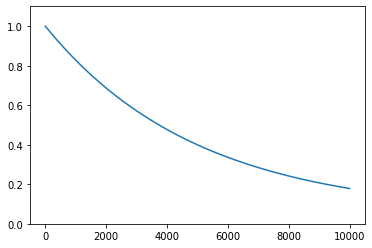

In [794]:
test_eps(10000)